# **Réseaux de neurones**

Projet de Master 2 TAL de Soumia DAAS, Ashley RATIER et la contribution de Myriam DULOR

## Objectif du projet


La génération de résumés automatique, de questions ou bien de réponses sont des sujets actuels. Notre projet a pour objectif de développer une interface web en python permettant de générer automatiquement des questions à partir d'un texte donné. L'objectif est de faciliter la création d'interrogations, contrôles ou examens pour les enseignants, dans la langue française.

## Description du système



>*Les architectures neuronales comme le modèle “Transformer” (Vaswani et al., 2017) permettent aujourd’hui d’obtenir de bonnes performances pour ces différents objectifs.*

**Présentation du Dataset :**

Le dataset [**CQuAE_synthetic**](https://https://huggingface.co/datasets/LsTam/CQuAE_synthetic) IA Extended est une extension du corpus original **CQuAE**  issu de la publication (Gerald et al., JEP/TALN/RECITAL 2024), enrichi par des questions générées automatiquement via GPT-4. Son objectif principal est d'élargir le volume de données d'entraînement pour les modèles spécialisés en question-réponse (QA) en français, en particulier dans le domaine éducatif.Chaque document dans le dataset est associé à quatre questions, chacune appartenant à une catégorie distincte, définie dans le cadre de CQuAE.
Le dataset est conçu pour entraîner et évaluer des modèles de question-réponse destinés à des applications éducatives en français.

Les questions générées sont classées en quatre catégories, en accord avec la typologie de CQuAE :

`Factual` (Factuelle) 🏛

Réponse : un fait ou une liste de faits (événement, personne, lieu, date…).
Ex : Quand Jeanne d'Arc a-t-elle été brûlée sur le bûcher ?

`Definition` (Définition) 📖

Réponse : une définition d’un concept ou d’un mot issu du texte.
Ex : Qu’est-ce qu’une monarchie absolue ?

`Course `(Explication de cours) 🎓

Réponse : une explication détaillée dépassant la simple description d’un fait.
Ex : Pourquoi la Révolution française a-t-elle conduit à l’abolition de la monarchie ?

`Synthesis` (Synthèse) 🔎

Réponse : intègre plusieurs éléments du texte ou requiert une interprétation pour être formulée.
Ex : En quoi les idées des Lumières ont-elles influencé la Révolution française ?

**Structure du dataset  :**
chaque entrée du dataset contient les champs suivants :

* `text (string)` : Le texte de référence sur lequel les questions sont basées.

* `qid (string/int) `: Identifiant unique de chaque question.

* `course / definition / factual / synthesis (dict) `:
Chaque type de question est stocké sous forme d’un dictionnaire contenant :
"question" : la question générée.
"answer" : la réponse associée.










In [ ]:
from datasets import load_dataset

dataset = load_dataset("LsTam/CQuAE_synthetic")["train"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12304 [00:00<?, ? examples/s]

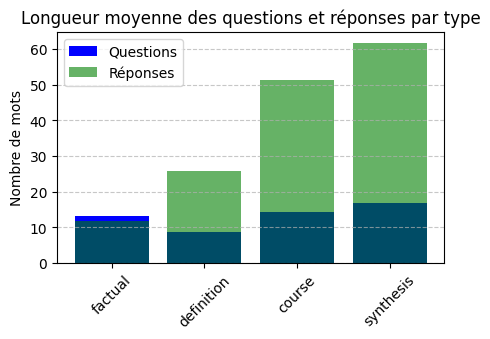

In [ ]:
# Calcul de la longueur moyenne des questions et réponses
lengths = {q: (sum(len(x[q]["question"].split()) for x in dataset if x[q]["question"]) / sum(bool(x[q]["question"]) for x in dataset),
               sum(len(x[q]["answer"].split()) for x in dataset if x[q]["answer"]) / sum(bool(x[q]["answer"]) for x in dataset))
           for q in ["factual", "definition", "course", "synthesis"]}

# Graphique avec labels bien lisibles
plt.figure(figsize=(5, 3))
plt.bar(lengths.keys(), [x[0] for x in lengths.values()], label="Questions", color="blue")
plt.bar(lengths.keys(), [x[1] for x in lengths.values()], label="Réponses", color="green", alpha=0.6)
plt.ylabel("Nombre de mots")
plt.title("Longueur moyenne des questions et réponses par type")
plt.xticks(rotation=45)  # Rotation des labels pour meilleure lisibilité
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Grille discrète
plt.show()


**Pourquoi avoir utilisé BARThez ?**

Pour ce projet de génération automatique de questions en français, nous avons choisi d'utiliser [**BARThez**](https://moussaKam/barthez), un modèle de type seq2seq (sequence-to-sequence) basé sur BART et pré-entraîné spécifiquement pour la langue française. Plusieurs raisons justifient ce choix:

* un modèle Encoder-Decoder : analyse le texte d'entrée `(le paragraphe du cours)`et
génère un texte en sortie `(une question cohérente basée sur le texte)`.

**💡 Pourquoi ne pas utiliser mBART ?**

Bien que **mBART** prenne en charge le français, il a été entraîné sur un corpus multilingue, ce qui réduit sa spécialisation pour une seule langue.


**BARThez**, bien qu'entraîné sur des corpus français généraux, n’était pas directement spécialisé pour la tâche de génération de questions éducatives. Nous avons donc réalisé un fine-tuning sur le dataset **CQuAE_synthetic**  pour adapter **BARThez** à notre tâche spécifique.

L'entraînement du modèle BARThez a été effectué sur Google Colab, une plateforme cloud qui permet d'exécuter du code Python avec des ressources GPU et TPU. Afin d'optimiser la performance et d'accélérer le fine-tuning, nous avons souscrit à un abonnement Google Colab Pro, ce qui nous a permis d'accéder à un GPU NVIDIA L4.

L'implémentation de notre projet repose sur l'utilisation de **PyTorch** et de la bibliothèque **Transformers** de **Hugging Face** pour fine-tuner le modèle **BARThez** sur le dataset **CQuAE_synthetic** . Cette section détaille les étapes de l'installation, du prétraitement des données, de l'entraînement du modèle et de la génération automatique de questions.
* Instalation des dépendances , bibliothèques (`transformers datasets torch accelerate sentencepiece huggingface_hub`, `AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer load_dataset `)

In [ ]:
!pip install transformers datasets torch accelerate sentencepiece huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Contexte ( difficultés rencontrées )

 L'idée première du projet était de générer dans le domaine de l'éducation un quizz à partir d'un corpus de cours pour aider les élèves à réviser. Générer les questions et les réponses pour entrainer le modèle s'est avéré être une tâche trop ardue, ainsi Ashley et Soumia ont envisagé de changer de projet. La deuxième idée de projet a été de détecter des fake-news. Elles ont essayé de comparer deux modèles existants. Elles ont fait plusieurs essais. Toutefois ce dernier sujet leur paraissait trop simple. Elles ont préféré trouver des solutions sur le thème de l'éducation et l'assistante virtuelle aux devoirs.

Elles se sont réparties le travail de programmation et d'essais informatiques. Ashley a rencontré des difficultés pour trouver un modèle en français et un corpus français en lien avec les fakes news.
Finalement, Soumia a réussi à faire tourner un modèle en lien avec la première idée du projet.
Ashley et Soumia ont dû faire face à des inconvénients comme l’optimisation des temps de calculs et des poids du modèles. Le modèle ne se sauvegardait pas correctement. Après plusieurs tentatives, elles ont trouvé la solution. En parallèle, elles ont essayé de finetuner un modèle pour classer les questions en fonction de leur difficulté : le modèle classait les questions, des plus simples aux plus complexes. Avec un corpus sous-dimensionné, la généralisation des résultats n'était pas satisfaisante.


---



##Méthodologie



1.   **Préparation** **des données**

Chargement du dataset : Nous avons utilisé le dataset "LsTam/CQuAE_synthetic" de Hugging Face.

* **Traitement des données :** Nous avons créé une fonction pour préparer les données. Cette fonction effectue plusieurs tâches importantes :

* Elle extrait le contexte et l'identifiant de la question (QID) de chaque exemple.

* Pour chaque type de question (définition, factuelle, synthèse), elle crée une entrée distincte.

* Elle formate l'entrée en incluant des marqueurs spéciaux pour le type de question, le contexte et le QID.

* Elle tokenize les entrées et les cibles (questions) en utilisant le tokenizer de BARThez.

* Elle applique un padding et une troncature pour s'assurer que toutes les séquences ont la même longueur.

* Elle prépare les labels en remplaçant les tokens de padding par -100 pour qu'ils soient ignorés lors du calcul de la perte.

* **Application de la préparation :** Cette fonction de préparation est appliquée à l'ensemble du dataset d'entraînement, créant ainsi un dataset prêt pour l'entraînement du modèle.

2.   **Entrainement**

* Chargement du modèle: BARThez a été chargé depuis Hugging Face avec son tokenizer associé.

* Le modèle a été transféré sur un appareil qui contient un (GPU).

* Configuration de l'entraînement : Nous avons défini les paramètres d'entraînement, incluant :

* Le nombre d'époques (8)

* La taille des batchs pour l'entraînement et l'évaluation.

* Les étapes de warmup et le taux de décroissance des poids.

* La stratégie d'évaluation et de sauvegarde.

* L'utilisation de la précision mixte (FP16) pour optimiser les performances

* Initialisation du Trainer : Nous avons utilisé la classe Trainer de Hugging Face, qui gère l'entraînement et l'évaluation du modèle. Nous lui avons fourni le modèle, les arguments d'entraînement, les datasets d'entraînement et d'évaluation, ainsi que le tokenizer.

* Entraînement : Le processus d'entraînement a été lancé, permettant au modèle d'apprendre à générer des questions à partir des contextes fournis.

* Sauvegarde du modèle : Après l'entraînement, le modèle a été sauvegardé sur Google Drive pour une utilisation ultérieure.

**Évaluation** :

Pour l'évaluation de notre modèle, nous nous sommes concentrées principalement sur la validation de la perte (`validation loss)`. Cette approche, bien que basique, nous a permis de suivre l'évolution des performances du modèle au cours de l'entraînement.

 Pendant l'entraînement, le modèle a été évalué à intervalles réguliers sur un sous-ensemble de validation. Cela nous a permis de suivre à la fois la perte d'entraînement (`training loss)` et la perte de validation.
 L'entraînement s'est déroulé sur 8 époques, totalisant 36 912 étapes, avec une durée totale d'environ 1 heure et 50 minutes sur un **GPU L4**.

Malheureusement, nous n'avons pas sauvegardé les résultats dans une matrice dédiée. Cependant, nous avons pu récupérer ces informations directement à partir des logs du notebook. Ces logs incluent les valeurs de perte d'entraînement et de validation à différentes étapes de l'entraînement.

Nous avions initialement prévu d'évaluer le modèle pendant l'entraînement à l'aide de métriques spécifiques à la génération de texte, telles que BLEU (pour mesurer la précision des n-grammes) et ROUGE (pour évaluer le rappel basé sur les correspondances textuelles). Malheureusement, nous avons oublié d'intégrer ces évaluations lors du premier entraînement. Lorsque nous nous sommes rendu compte de cet oubli, nous avons voulu relancer l'entraînement avec ces métriques intégrées. Ces métriques auraient permis une évaluation plus approfondie de la qualité linguistique et sémantique des questions générées par le modèle. Cependant, en raison des limitations financières liées à notre abonnement Google Colab Pro (insuffisance de crédits), nous n'avons pas pu relancer l'entraînement avec ces métriques intégrées.




##Résultats et Exemples

**Pourquoi n’avons-nous pas pu enregistrer les résultats et comment les avons-nous récupérés ?**
* Lors de l'entraînement du modèle BARThez avec Hugging Face Trainer, nous avons utilisé les paramètres logging_steps=10 et evaluation_strategy="steps", ce qui signifie que les pertes d'entraînement (Training Loss) et de validation (Validation Loss) ont bien été enregistrées dans les logs internes de Trainer.

* Plutôt que de réentraîner complètement le modèle, nous avons extrait les valeurs affichées durant l'entraînement et les avons manuellement enregistrées sous forme de listes en Python.
Nous avons ensuite utilisé ces données pour :

 - Tracer un graphique de l'évolution de la perte au fil du temps 📊.

 - Identifier la meilleure itération du modèle (où la Validation Loss est la plus basse).
 -Analyser la convergence du modèle sans avoir à refaire un entraînement coûteux en ressources.

In [ ]:
import matplotlib.pyplot as plt

# Étapes d'entraînement
steps = [
    500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000,
    8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000,
    15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500,
    22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000,
    28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500,
    35000, 35500, 36000, 36500
]

# Training Loss à chaque step
training_loss = [
    1.6995, 1.6963, 1.5371, 1.4817, 1.3982, 1.2988, 1.4638, 1.3154, 1.2878, 1.0824,
    1.2275, 1.1804, 1.1075, 1.2189, 1.243, 1.0574, 1.0901, 0.9808, 0.9056, 0.9866,
    1.0364, 1.032, 0.8213, 0.9237, 0.8404, 0.9344, 1.0035, 0.7721, 0.8508, 0.7342,
    0.7501, 0.8014, 0.7435, 0.8617, 0.7386, 0.7537, 0.6731, 0.6015, 0.6438, 0.6682,
    0.661, 0.6701, 0.7042, 0.6767, 0.6835, 0.692, 0.5573, 0.522, 0.5957, 0.6348,
    0.6224, 0.5979, 0.7254, 0.5812, 0.5467, 0.5553, 0.5897, 0.4947, 0.4356, 0.5634,
    0.5058, 0.5318, 0.5583, 0.577, 0.4464, 0.4751, 0.5395, 0.4919, 0.4705, 0.4812,
    0.4956, 0.4823, 0.5099
]

# Validation Loss à chaque step
validation_loss = [
    1.1069, 0.9629, 0.9115, 0.8708, 0.8353, 0.7919, 0.7564, 0.7333, 0.7191, 0.6763,
    0.6528, 0.6534, 0.6318, 0.6196, 0.5828, 0.5732, 0.5675, 0.5427, 0.5226, 0.5237,
    0.5023, 0.4841, 0.4736, 0.4586, 0.4434, 0.4366, 0.4286, 0.4082, 0.4020, 0.4003,
    0.3900, 0.3745, 0.3638, 0.3597, 0.3408, 0.3362, 0.3267, 0.3135, 0.3035, 0.2979,
    0.2974, 0.2907, 0.2874, 0.2778, 0.2683, 0.2671, 0.2612, 0.2515, 0.2441, 0.2405,
    0.2357, 0.2313, 0.2271, 0.2179, 0.2141, 0.2094, 0.2045, 0.2022, 0.2078, 0.1990,
    0.1930, 0.1899, 0.1873, 0.1840, 0.1815, 0.1794, 0.1807, 0.1776, 0.1782, 0.1746,
    0.1736, 0.1731, 0.1709
]


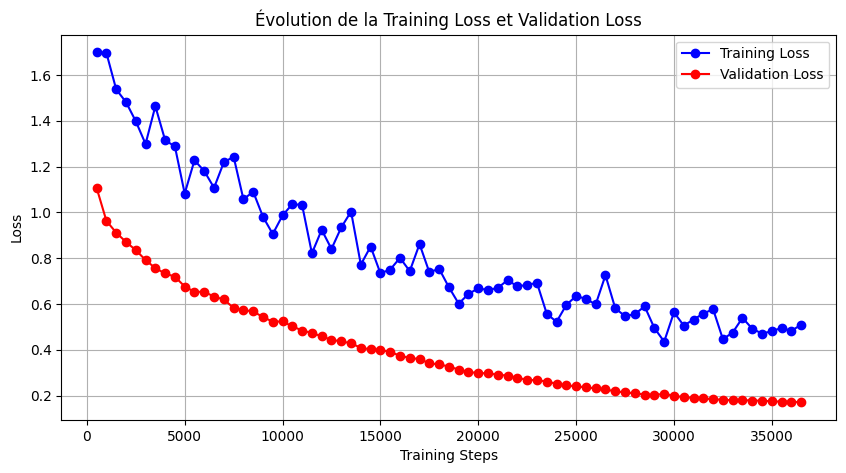

In [ ]:
# Tracer les pertes d'entraînement et de validation
plt.figure(figsize=(10, 5))

# Training Loss
plt.plot(steps, training_loss, label="Training Loss", color='blue', marker='o')

# Validation Loss
plt.plot(steps, validation_loss, label="Validation Loss", color='red', marker='o')

# Titres et labels
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Évolution de la Training Loss et Validation Loss")
plt.legend()
plt.grid()

# Afficher le graphique
plt.show()


L'entraînement du modèle **BARThez** a montré une convergence réussie, avec une **Training Loss** passant de **1.6995** à **0.5099** et une **Validation** **Loss** chutant de **1.1069**  à  **0.1709**  sur 36 500 steps. L'absence de surapprentissage et la baisse continue des pertes indiquent un modèle performant et bien généralisé. Le meilleur modèle a été atteint à Step **36 500**, mais l'entraînement aurait pu être optimisé en s'arrêtant autour de **30 000** steps pour économiser des ressources.

Nous avons tout de même choisi de montrer comment l’évaluation aurait pu être réalisée en appliquant notre modèle sur un exemple spécifique. Cet exemple permet malgré tout d'illustrer le processus de génération et d’évaluation, bien que les résultats ne reflètent pas une analyse complète sur l’ensemble du corpus d’évaluation.

### Explications des métriques BLEU, METEOR et ROUGE

**BLEU** : évalue la similarité des n-grams.

**METEOR** : métrique qui prend en compte les synonymes, les formes fléclies et l'ordre des mots

**ROUGE** : compare la structure globale

In [ ]:
pip install transformers datasets torch evaluate rouge_score nltk

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.2 MB/s eta 0:00:00
   ━

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from datasets import load_dataset
import torch
import evaluate

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement du modèle et du tokenizer BARThez
model_path = "SOUMI23/generator_question_barthez"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(device)

In [ ]:
# Fonction pour générer des questions
def generate_multiple_questions(text, model, tokenizer, device, question_types=['definition', 'factual', 'synthesis']):
    questions = []

    # On vérifie que le texte n'est pas vide
    if not text.strip():
        return [(q_type, "Le texte est vide.") for q_type in question_types]

    for q_type in question_types:
        input_text = f"<type:{q_type}> Contexte: {text}"

        inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=128,
                num_return_sequences=1,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                no_repeat_ngram_size=2
            )

        generated_question = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        if not generated_question:
            generated_question = "Aucune question générée."

        questions.append((q_type, generated_question))

    return questions

In [ ]:
# Exemple d'utilisation
text = """
La pollution atmosphérique tue 5,5 millions de personnes par an dans le monde (dont 2,6 millions de décès indirects) selon des chiffres 2016 de la Banque mondiale: elle est devenue le quatrième facteur de décès prématuré sur Terre. Maladies cardiovasculaires, cancers des poumons, maladies pulmonaires chroniques, infections respiratoires... La pollution de l'air est coupable d'un décès sur dix dans le monde, six fois plus que le paludisme. La cause est l'Homme et son activité, par les industries, le trafic routier, les incinérateurs de déchets, le chauffage individuel et les centrales électriques aux combustibles fossiles. La pollution dans les villes provoque souvent un brouillard de polluants ou smog, souvent révélateurs de la densité de micro-particules et de l'impact du CO2 et autres polluants sur l'environnement.
"""
# Fonction pour générer des questions
def generate_multiple_questions(text, model, tokenizer, device, question_types=['definition', 'factual', 'synthesis']):
    questions = []

    # Vérifier si le texte est vide
    if not text.strip():
        return [(q_type, "Aucune question générée : texte vide.") for q_type in question_types]

    for q_type in question_types:
        input_text = f"<type:{q_type}> Contexte: {text}"

        inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=128,
                num_return_sequences=1,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                no_repeat_ngram_size=2
            )

        generated_question = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        if not generated_question:
            generated_question = "Aucune question générée."

        questions.append((q_type, generated_question))

    return questions

In [ ]:
# Exemple d'utilisation
text = """
La pollution atmosphérique tue 5,5 millions de personnes par an dans le monde (dont 2,6 millions de décès indirects) selon des chiffres 2016 de la Banque mondiale: elle est devenue le quatrième facteur de décès prématuré sur Terre. Maladies cardiovasculaires, cancers des poumons, maladies pulmonaires chroniques, infections respiratoires... La pollution de l'air est coupable d'un décès sur dix dans le monde, six fois plus que le paludisme. La cause est l'Homme et son activité, par les industries, le trafic routier, les incinérateurs de déchets, le chauffage individuel et les centrales électriques aux combustibles fossiles. La pollution dans les villes provoque souvent un brouillard de polluants ou smog, souvent révélateurs de la densité de micro-particules et de l'impact du CO2 et autres polluants sur l'environnement.
"""

# Génération des questions
generated_questions = generate_multiple_questions(text, model, tokenizer, device)

In [ ]:
# Affichage des questions générées
for q_type, question in generated_questions:
    print(f"{q_type.capitalize()} question: {question}")

In [ ]:
# Chargement des métriques BLEU, METEOR et ROUGE
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
rouge = evaluate.load("rouge")

def compute_bleu(generated_questions, reference_questions):
    formatted_references = [[ref] for ref in reference_questions]
    results = bleu.compute(predictions=generated_questions, references=formatted_references)
    return results["bleu"]

def compute_meteor(generated_questions, reference_questions):
    formatted_references = [[ref] for ref in reference_questions]
    results = meteor.compute(predictions=generated_questions, references=formatted_references)
    return results["meteor"]

def compute_rouge(generated_questions, reference_questions):
    formatted_references = [[ref] for ref in reference_questions]
    results = rouge.compute(predictions=generated_questions, references=formatted_references)
    return results["rougeL"]

# Exemple de références
reference_questions = [
    "Quelles sont les conséquences de la pollution atmosphérique ?",
    "Quel est l'impact du CO2 sur l'environnement ?",
    "Pourquoi la pollution est-elle considérée comme un facteur de décès prématuré ?"
]

# On extrait les questions générées
generated_only = [question for _, question in generated_questions]

# Calcul des scores BLEU, METEOR et ROUGE
bleu_score = compute_bleu(generated_only, reference_questions)
meteor_score = compute_meteor(generated_only, reference_questions)
rouge_score = compute_rouge(generated_only, reference_questions)

print(f"BLEU Score : {bleu_score:.4f}")
print(f"METEOR Score : {meteor_score:.4f}")
print(f"ROUGE-L Score : {rouge_score:.4f}")


### Interprétation des résultats

La métrique **BLEU** n'est pas la plus adaptée car le modèle ne génère pas exactement la meme question, ce qui n'est pa sun poitn négatif car il génère tout de même des questions pertinentes.

La métrique **METEOR** détecte une certaine similarité car celle ci prend en compte les synonymes. Le modèle reformule pas mal les questions.

La métrique **ROUGE** montre que les questions générées utilisent des mots très différents que les références avec un score très bas.

# **Interface**

## Description du système

L'interface repose sur du HTML et du CSS.
Elle communique avec une API en FastAPI.

index.hmtl : page principale de l'interface  
style.css : style de la page

Fonctionnalités principales :

- Remplissage du texte à traiter par l'utilisateur
- Choix du type de questions (définition, factuel, synthèse)
- Le modèle génère les questions

L'interface contient :
- un champ "textarea" où l'utilisateur peut coller le texte sur lequel il veut générer des questions
- une liste de choix de type de questions
  -  défintion,
  - factuel,
  - synthèse
- un bouton de soumission "générer"
- un espace d'affichage des questions générées

## Implémentation

Le fichier api.py contient :

- L'initialisation de l'**API** avec **FastAPI**
- La configuration de **CORS** pour permettre les requêtes du **frontend**
- Le chargement du **modèle** et du **tokenizer** via Hugging Face
- Une fonction de **découpage en phrases** pour améliorer la précision des questions générées
- Une fonction de **génération de questions** en fonction des **types demandés**
- Un **endpoint POST** qui prend un texte et renvoie des questions générées
- Un **endpoint GET** pour tester si l’API est en ligne

Le fichier index.html contient :
- La structure principale &lt;**body**&gt;
- Un &lt;**textarea**&gt; pour entrer du texte
- Un &lt;**input type="checkbox**"&gt; pour sélectionner le type de questions
- Un &lt;**button**&gt; pour envoyer la demande
- Une &lt;**div**&gt; pour afficher le résultat


Le fichier style.css contient :  
- **body** : style du contenu  
- **.container** : cadre blanc centré
- **textarea** : style de la zone de texte
- **.checkbox-title** : mise en forme du titre des types de questions
- **.checkbox** : cases à cocher
- **button** : style du bouton "générer"
- **.result** : cadre du résultat
- **.question** : style des questions


## Résultats

Lorsque l'utilisateur rentre un texte dans le champ de saisie, une fois avoir défini le type de questions qu'il souhaite, il peut appuyer sur le bouton "générer". Ansi les questions s'afficheront sous cette forme :
![Description de l’image](image.png)



## Améliorations possibles

Pour améliorer ce projet, nous aurions pu tout d'abord l'évaluer suite au finet-tuning. Nous aurions également pu, utiliser une méthode plus poussée telle que la similarité sémantique afin de voir si nos questions ont du sens. Nous aurions pu intégrer du JavaScript afin de rendre l’interface plus dynamique. Par exemple, l’ajout d’une barre de progression aurait permis d’indiquer visuellement que le modèle est en cours de chargement, afin d'offir un meilleur retour utilisateur, notamment lorsque le traitement prend du temps. Nous aurions également pu modifier certains paramètres afin d'augmenter la vitesse du modèle.

Pour conclure nos résultats semblent globalement satisfaisants, le modèle fonctionne plutôt bien malgré quelles erreurs dans les questions générées avec des questions parfois inutiles.

# Bibliographie

Gerald T., Tamames L., Ettayeb S., Paroubek P., and Vilnat A.. 2024. CQuAE : Un nouveau corpus de question-réponse pour l’enseignement. In Actes de la 31ème Conférence sur le Traitement Automatique des Langues Naturelles, volume 1 : articles longs et prises de position, pages 50–63, Toulouse, France. ATALA and AFPC.

Vaswani A., Shazeer N., Parmar N., Uszkoreit J., Jones L., Gomez A. N., Kaiser L. & Polosukhin I. 2017. Attention is all you need. In I. GUYON, U. VON LUXBURG, S. BENGIO, H. M. WALLACH, R. FERGUS, S. V. N. VISHWANATHAN & R. GARNETT, Éds., Advances in Neural Information Processing Systems 30 : Annual Conference on Neural Information Processing Systems 2017, December 4-9, 2017, Long Beach, CA, USA, p. 5998–6008.

 Licence dataset : Creative Commons Attribution-NonCommercial 4.0 International